In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from scipy.stats import poisson, norm, invgamma, uniform

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
J = 6

np.random.seed(111)
N = poisson.rvs(3, size=J, loc=10)

MU  = -9
TAU = 1
GAMMA = 2
ZETA = 3
RHO = 3
NU  = 4

np.random.seed(111)
ALPHA  = norm.rvs(size=J, loc=MU, scale=TAU)
BETA   = norm.rvs(size=J, loc=GAMMA, scale=ZETA)
SIGMA2 = invgamma.rvs(size=J, a=NU/2, scale=NU/2*RHO**2)

SIGMA = np.sqrt(SIGMA2)

VARIABLE = 'Y'
PREDICTOR = 'X'

ALPHA_LEVEL = 0.05

Create the data

In [3]:
np.random.seed(111)
X = uniform.rvs(size=N[0])
Y = norm.rvs(size=N[0], loc=ALPHA[0] + BETA[0] * (X-np.mean(X)), scale=SIGMA[0])
Dat = pd.DataFrame(np.array([Y, X, [0]*N[0]]).T)

for j in range(1,J):
    X = uniform.rvs(size=N[j])
    Y = norm.rvs(size=N[j], loc=ALPHA[j] + BETA[j] * (X-np.mean(X)), scale=SIGMA[j])
    DatAux = pd.DataFrame(np.array([Y, X, [j]*N[j]]).T)
    Dat = pd.concat([Dat, DatAux])

Dat = Dat.rename(columns={0:VARIABLE, 1:PREDICTOR, 2:'Region'})
Dat['Region'] = Dat['Region'].astype(int)

In [4]:
Dat = Dat[[VARIABLE, PREDICTOR, 'Region']]

---

Calculate the statistics per region

In [5]:
DatRegion = Dat[[PREDICTOR, VARIABLE, 'Region']].groupby(['Region']).mean().reset_index()
DatRegion = DatRegion.rename(columns={PREDICTOR: PREDICTOR + 'Region'})

Dat = pd.merge(Dat, DatRegion[[PREDICTOR + 'Region', 'Region']], on='Region')

---

Regression model with separate $\alpha$'s and $\beta$'s

In [6]:
with pm.Model() as ModelSeparateAlphaSeparateBeta:
    Alpha = pm.Flat('Alpha', shape=J)
    Beta  = pm.Flat('Beta', shape=J)

    Sigma = pm.HalfFlat('Sigma', shape=J)
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic(
        'MeanIncome'
        , Alpha[Dat['Region']] + Beta[Dat['Region']] * (Dat[PREDICTOR] - Dat[PREDICTOR + 'Region']))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma[Dat['Region']], observed=Dat[VARIABLE])

Get a sample from the posterior and the posterior predictive

In [7]:
with ModelSeparateAlphaSeparateBeta:
    TraceSeparateAlphaSeparateBeta = pm.sample()
    TraceSeparateAlphaSeparateBeta.extend(pm.sample_posterior_predictive(TraceSeparateAlphaSeparateBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [Income]


---

Regional average income, ratio of income per year-of-education

In [8]:
PosteriorAlpha = az.summary(
    TraceSeparateAlphaSeparateBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'Alpha'
)

PosteriorAlpha = PosteriorAlpha.rename(
    columns = {
        'mean': 'HatAlpha'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100) + '%': 'LowAlpha'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100) + '%': 'UppAlpha'
    }
)

In [9]:
PosteriorBeta = az.summary(
    TraceSeparateAlphaSeparateBeta
    , kind = 'stats'
    , hdi_prob = 1-ALPHA_LEVEL
    , var_names = 'Beta'
)

PosteriorBeta = PosteriorBeta.rename(
    columns = {
        'mean': 'HatBeta'
        , 'hdi_' + str((ALPHA_LEVEL/2)*100) + '%': 'LowBeta'
        , 'hdi_' + str((1-ALPHA_LEVEL/2)*100) + '%': 'UppBeta'
    }
)

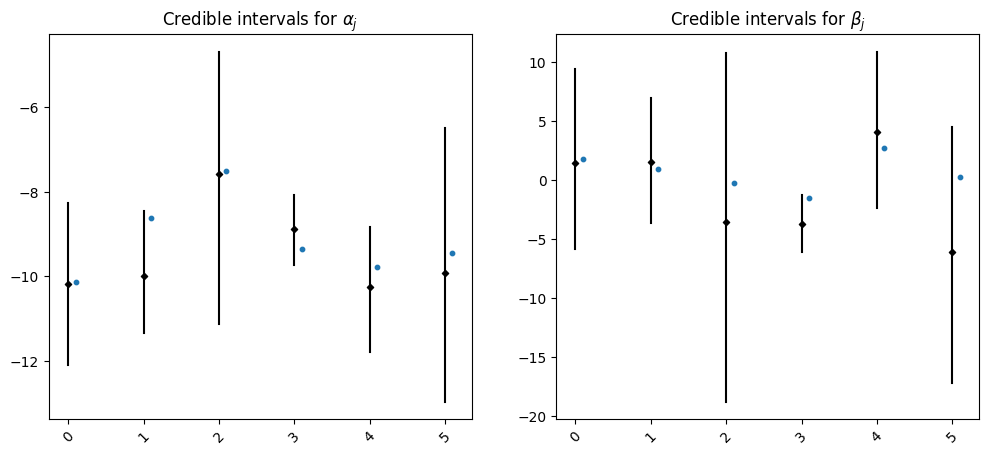

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

for k, ax in enumerate(axs.reshape(-1)):
    if k == 0:
        ax.scatter(range(J), PosteriorAlpha['HatAlpha'], marker='D', color='k', s=10)
        ax.scatter(np.arange(0.1, J+0.1, 1), ALPHA, marker='o', color='C0', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorAlpha['LowAlpha'][j], PosteriorAlpha['UppAlpha'][j]],
                color='k'
            )

        ax.set_title(r'Credible intervals for $\alpha_j$')
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)
    else:
        ax.scatter(range(J), PosteriorBeta['HatBeta'], marker='D', color='k', s=10)
        ax.scatter(np.arange(0.1, J+0.1, 1), BETA, marker='o', color='C0', s=10)

        for j in range(J):
            ax.plot(
                [j, j],
                [PosteriorBeta['LowBeta'][j], PosteriorBeta['UppBeta'][j]],
                color='k'
            )
            
        ax.set_title(r'Credible intervals for $\beta_j$')
        ax.set_xticks(range(J), labels=DatRegion['Region'], rotation=45)

Scatterplot

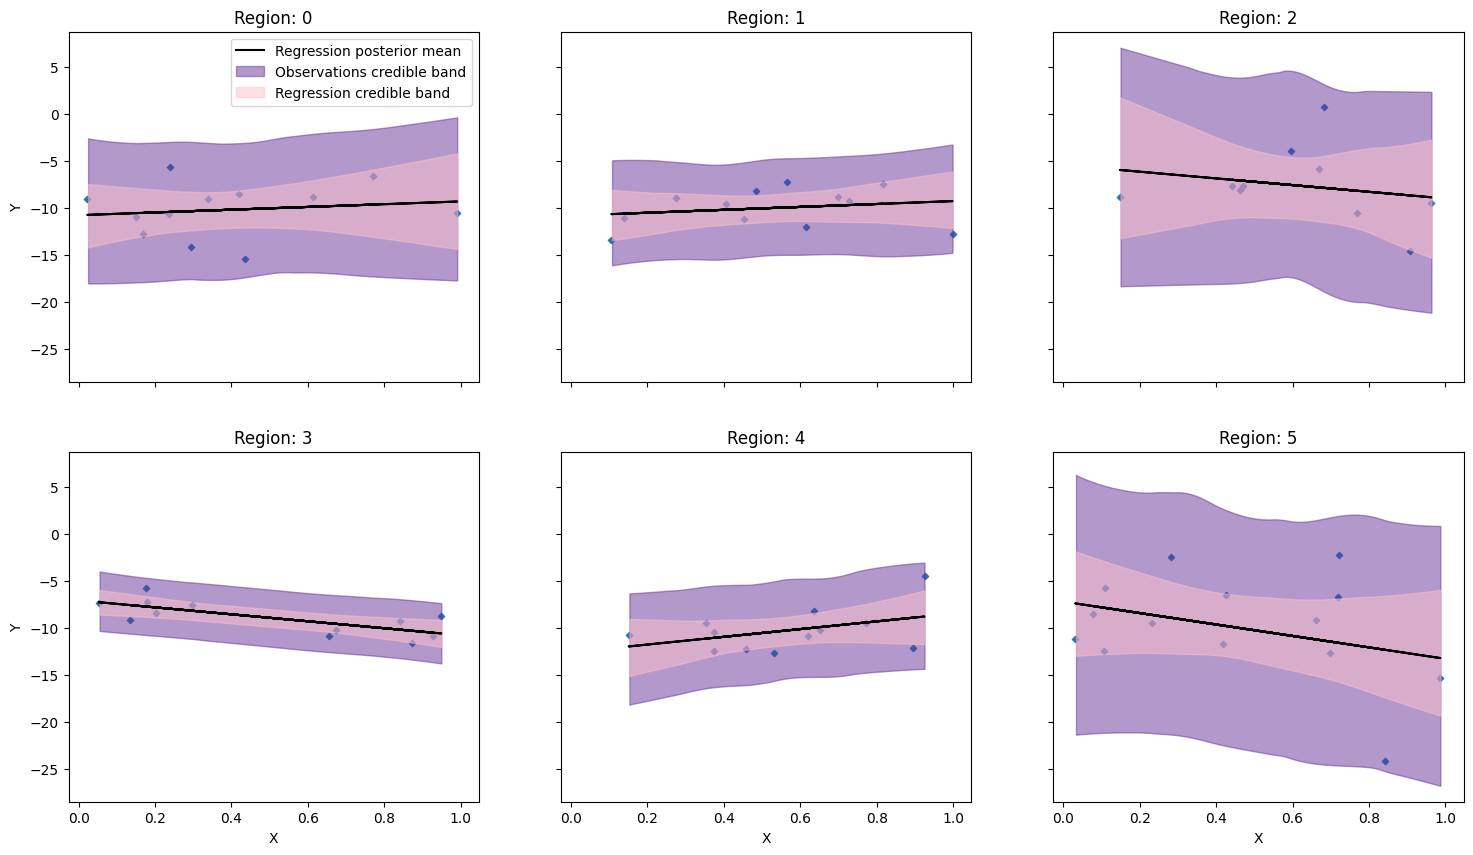

In [13]:
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(18,10))

for k, ax in enumerate(axs.reshape(-1)):
    Aux = Dat[Dat['Region']==k]

    ax.scatter(
        Aux[PREDICTOR]
        , Aux[VARIABLE]
        , marker = 'D'
        , s = 10
    )

    ax.plot(
        Aux[PREDICTOR]
        , TraceSeparateAlphaSeparateBeta.posterior.MeanIncome[:,:,Aux.index].mean(('chain', 'draw'))
        , label="Regression posterior mean"
        , color='k'
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceSeparateAlphaSeparateBeta.posterior_predictive.Income[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='rebeccapurple'
        , fill_kwargs={'alpha': 0.5, 'label':"Observations credible band"}
        , ax = ax
    )

    az.plot_hdi(
        Aux[PREDICTOR]
        , TraceSeparateAlphaSeparateBeta.posterior.MeanIncome[:,:,Aux.index]
        , hdi_prob=1-ALPHA_LEVEL
        , color='pink'
        , fill_kwargs={'alpha': 0.5, 'label':"Regression credible band"}
        , ax = ax
    )

    ax.set_title('Group: ' + str(k))

    if k in [0,3]:
        ax.set_ylabel(VARIABLE)
        
        if k == 0:
            ax.legend()

    if k in [3,4,5]:
        ax.set_xlabel(PREDICTOR)